<a href="https://colab.research.google.com/github/rupanshu1710/Face-Mask-Detection/blob/main/Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
#Data Preprocessing
INIT_LR = 1e-4
EPOCHS = 30
BS = 32

DIRECTORY = "/content/drive/MyDrive/Face-Mask-Detection/dataset"
CATEGORIES = ["with_mask","without_mask"]

print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(256,256))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)#(	Fit label binarizer and transform multi-class labels to binary labels)
labels = to_categorical(labels)#(https://www.geeksforgeeks.org/python-keras-keras-utils-to_categorical/)

data = np.array(data,dtype="float32")
labels = np.array(labels)

#split the data
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

#data augmentation
Augmented_data = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")
           





[INFO] loading images...


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[INFO] compiling model...
[INFO] training head...
Epoch 1/30
96/96 [==============================] - 43s 422ms/step - loss: 0.4344 - accuracy: 0.8334 - val_loss: 0.0962 - val_accuracy: 0.9819
Epoch 2/30
96/96 [==============================] - 40s 415ms/step - loss: 0.1081 - accuracy: 0.9772 - val_loss: 0.0606 - val_accuracy: 0.9806
Epoch 3/30
96/96 [==============================] - 39s 410ms/step - loss: 0.0706 - accuracy: 0.9841 - val_loss: 0.0484 - val_accuracy: 0.9832
Epoch 4/30
96/96 [==============================] - 40s 412ms/step - loss: 0.0519 - accuracy: 0.9876 - val_loss: 0.0453 - val_accuracy: 0.9845
Epoch 5/30
96/96 [==============================] - 40s 412ms/step - loss: 0.0486 - accuracy: 0.9829 - val_loss: 0.0408 - val_accuracy: 0.9806
Epoch 6/30
96/96 [==============================] - 40s 411ms/step - loss: 0.0354 - accuracy: 0.9915 - val_loss: 0.0382 - val_accuracy: 0.9806
Epoch 7/30
96/96 [==============================] - 39s 411ms/step - loss: 0.0334 - accuracy

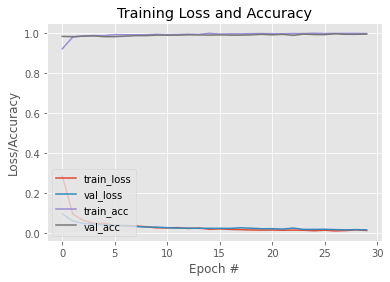

In [ ]:
#Build the model
base_model = MobileNetV2(include_top=False,weights="imagenet",input_tensor=Input(shape=(256,256, 3)))
base_model_output = base_model.output
layer1 = AveragePooling2D(pool_size=(7,7))(base_model_output)
layer2 = Flatten(name = 'Flatten')(layer1)
layer3 = Dense(128, activation='relu')(layer2)
layer4 = Dropout(0.2)(layer3)
head_model = Dense(2, activation='softmax')(layer4)

model = Model(inputs=base_model.input, outputs=head_model)

for layer in base_model.layers:
  layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	Augmented_data.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

